# Demonstration of MDMM and speed gains using Rcpp

In [1]:
# Rcpp version of MDMM
source('lib/mdmmCpp.R')
# Base R version of MDMM
source('lib/MDMM_r.R')

## Code to generate simulated data
###   - 9000 data points
###   - 3 clusters of 3000 data points each

In [2]:
library(MASS)
cor2cov <- function( corr, std)  {
  return( diag(std) %*% corr %*% diag(std) )
}

mu <- list(c(1,2),c(4,6),c(0,2))
varc <- list( cor2cov(matrix(c(1,0.8,0.8,1),ncol=2,nrow=2),c(1,2.4)),
              cor2cov(matrix(c(1,0.5,0.5,1),ncol=2,nrow=2),c(1,1)),
              cor2cov(matrix(c(1,0.2,0.2,1),ncol=2,nrow=2),c(3,2))
)

P_c <- list(c(0.5,0.4,0.03,0.03,0.04),c(0.03,0.03,0.04,0.5,0.4),c(0.05,0.05,0.9,0.05,0.05))

P_m <- list(list(c(0.9,0.05,0.05),c(0.5,0.5)),list(c(0.9,0.05,0.05),c(0.5,0.5)),list(c(0.2,0.4,0.4),c(0.2,0.8)))

dat_sim <- list()
for(i in 1:3) {
  N_g <- round(runif(1,3000,3000))
  dat_sim <- c(dat_sim, list( cbind(rep(i,N_g),
                                    mvrnorm(N_g, mu[[i]], varc[[i]]),
                                    apply( t(rmultinom(N_g, 1, P_c[[i]])),1,function(x) which(x>0)),
                                    t(sapply(1:N_g, function(x) rmultinom(1, round(runif(1, 30, 300)), P_m[[i]][[1]]))),
                                    t(sapply(1:N_g, function(x) rmultinom(1, round(runif(1, 5, 30)), P_m[[i]][[2]])))
                                    )
                              )
                  )
}
dat_sim <- do.call('rbind',dat_sim)
dim(dat_sim)

[1] 9000    9

### Breaking down the simulated data into the labels and explanatory variables

In [3]:
original_clusters <- dat_sim[,1]
dat <- data.frame( dat_sim[,2:3], as.factor(dat_sim[,4]), apply(dat_sim[,5:9],2,as.integer) )
colnames(dat) <- paste0('x',1:8)

### Running the C++ version of the MDMM function

------------ Attempt ID: 1 ------------
Current Iteration: 1
      Convergence: 0.927943
    loglikelihood: -516245
Current Iteration: 2
      Convergence: 0.606089
    loglikelihood: -344081
Current Iteration: 3
      Convergence: 0.561942
    loglikelihood: -118480
Current Iteration: 4
      Convergence: 0.159181
    loglikelihood: -118355
Current Iteration: 5
      Convergence: 0.127873
    loglikelihood: -118355
Current Iteration: 6
      Convergence: 0.137549
    loglikelihood: -118356
Current Iteration: 7
      Convergence: 0.239481
    loglikelihood: -118358
Current Iteration: 8
      Convergence: 0.312221
    loglikelihood: -118366
Current Iteration: 9
      Convergence: 0.396487
    loglikelihood: -118391
Current Iteration: 10
      Convergence: 0.475184
    loglikelihood: -118384
Current Iteration: 11
      Convergence: 0.563094
    loglikelihood: -118086
Current Iteration: 12
      Convergence: 0.582883
    loglikelihood: -117359
Current Iteration: 13
      Convergence: 0.68

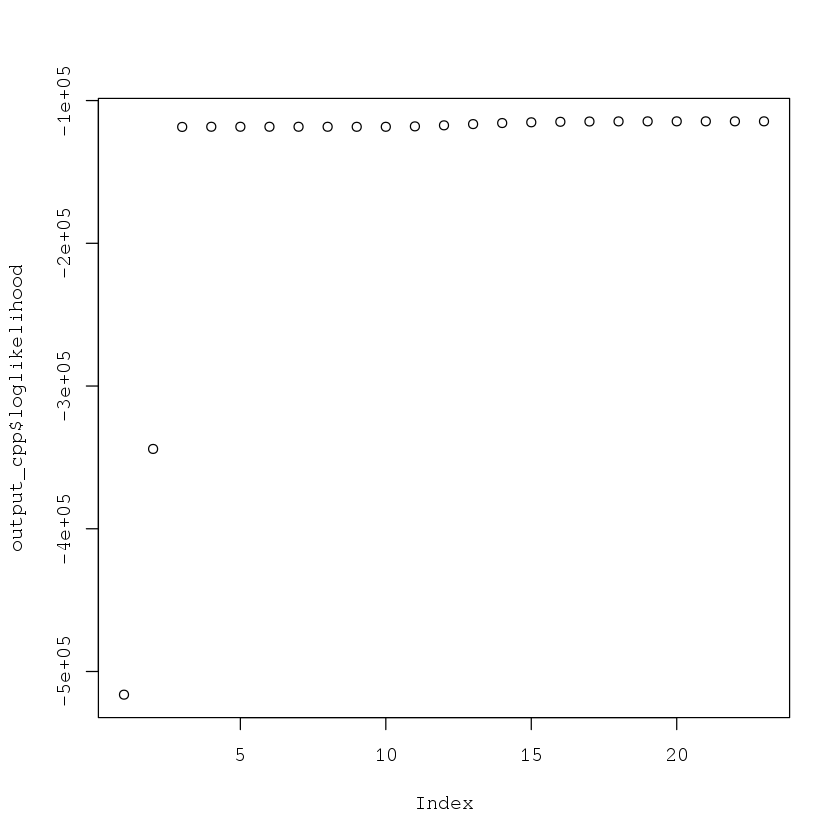

In [21]:
#*******************************************************************************************************
#********************* Important! **********************************************************************
# [1] MDMM automatically does a one-hot encoding of factor data (or in non-R language, categorical data)
# [2] "idx_m" is to list index of fields containing multinomial data to allow function to identify 
#     multinomial variables. In the example there are 2 sets defined by indices 4-6 and 7-8 respectively
#*******************************************************************************************************
idx_m <- list(4:6,7:8)
t_0 <- proc.time()[3]
output_cpp <- MDMM( dat, K = 3, multinomial_indices = idx_m, est_cov = TRUE, attempts = 3)
t_N <- proc.time()[3]
plot(output_cpp$loglikelihood)
print(paste0("Time taken to run cpp verions 3 times is: ",t_N-t_0, "secs"))

### Running the R version of the MDMM function

[1] "        Current iteration: 1"
[1] "|theta_tp1 - theta_t|_inf: 0.915224310731713"
[1] "            loglikelihood: -516259.055028245"
[1] "        Current iteration: 2"
[1] "|theta_tp1 - theta_t|_inf: 0.686728305077686"
[1] "            loglikelihood: -431523.096187836"
[1] "        Current iteration: 3"
[1] "|theta_tp1 - theta_t|_inf: 0.545998570879152"
[1] "            loglikelihood: -117996.790831501"
[1] "        Current iteration: 4"
[1] "|theta_tp1 - theta_t|_inf: 0.127871612296223"
[1] "            loglikelihood: -117958.490130556"
[1] "        Current iteration: 5"
[1] "|theta_tp1 - theta_t|_inf: 0.0936378395878927"
[1] "            loglikelihood: -117955.949717645"
[1] "        Current iteration: 6"
[1] "|theta_tp1 - theta_t|_inf: 0.205498829540383"
[1] "            loglikelihood: -117956.894513268"
[1] "        Current iteration: 7"
[1] "|theta_tp1 - theta_t|_inf: 0.363893750476514"
[1] "            loglikelihood: -117967.116080368"
[1] "        Current iteration: 8"
[1] "

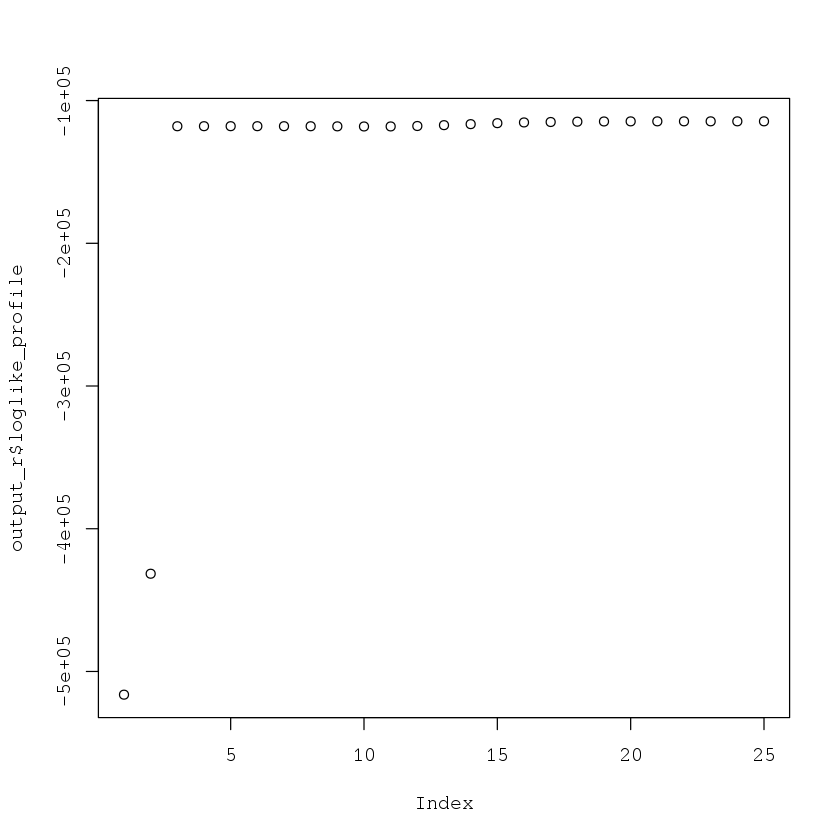

In [22]:
t_0 <- proc.time()[3]
output_r <- MDMM_r( dat, K = 3, multinomial_indices = idx_m, est_cov = TRUE)
t_N <- proc.time()[3]
print(paste0("Time taken to run R version once is: ",t_N-t_0, "secs"))
plot(output_r$loglike_profile)

### Compare original cluster groupings to inferred cluster groupings

In [26]:
eval_clusters <- apply(output_cpp$data_prob, 1, function(x) which(x == max(x)) )
table(original_clusters)
table(eval_clusters)

original_clusters
   1    2    3 
3000 3000 3000 

eval_clusters
   1    2    3 
3022 3000 2978 

In [28]:
#identify indices for each class
ipt_class <- unlist(lapply(dat,class))
idx_ftr <- which(ipt_class %in% c('factor','logical'))
idx_mult <-list(4:6,7:8)
idx_num <- setdiff(1:ncol(dat),c(idx_ftr,unlist(idx_mult)))

### Demonstrate segmentation capability based on the numerical variables slice of the data

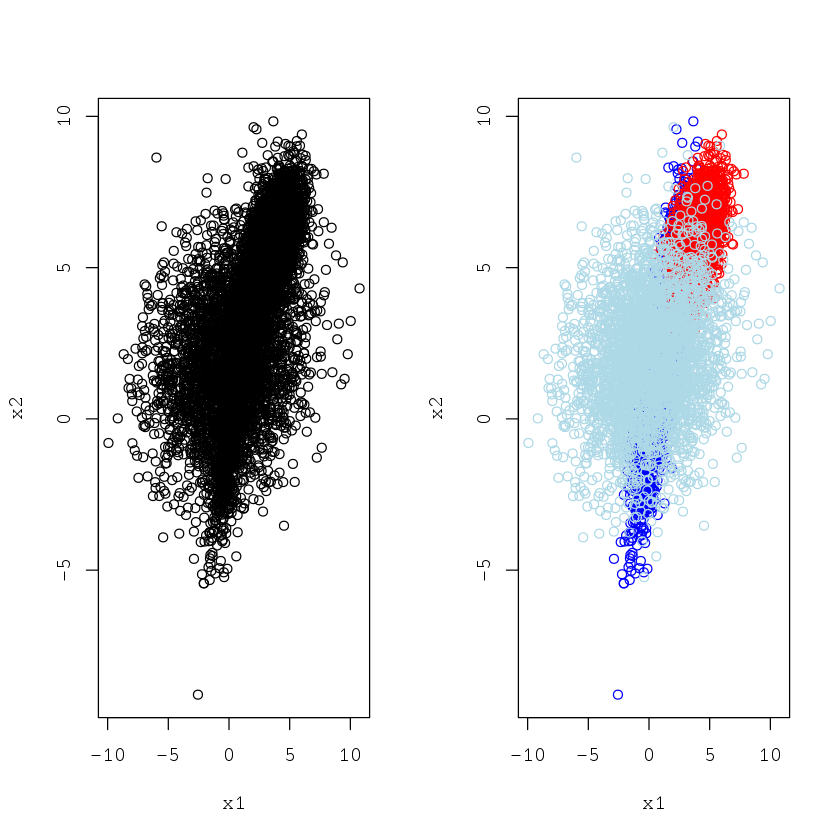

In [31]:
par(mfrow=c(1,2))
# Plot the numerical
plot(dat[,idx_num], 
     xlim = c(min(dat[,idx_num][,1]),max(dat[,idx_num][,1])), 
     ylim = c(min(dat[,idx_num][,2]),max(dat[,idx_num][,2])), col = 'black' )
# Plot the numerical with respect to the inferred segmentation
plot(dat[,idx_num][original_clusters==1,], 
     xlim = c(min(dat[,idx_num][,1]),max(dat[,idx_num][,1])), 
     ylim = c(min(dat[,idx_num][,2]),max(dat[,idx_num][,2])), col = 'blue' )
points(dat[,idx_num][original_clusters==2,],col='red')
points(dat[,idx_num][original_clusters==3,],col='lightblue')

### Visualize the segment distribution against the population distribution for each variable

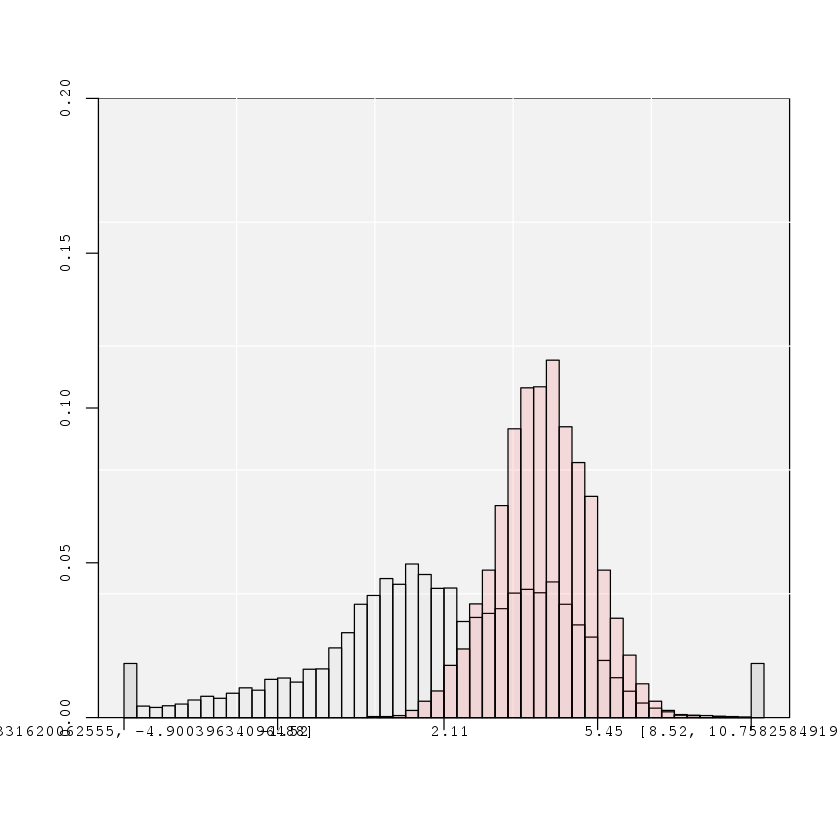

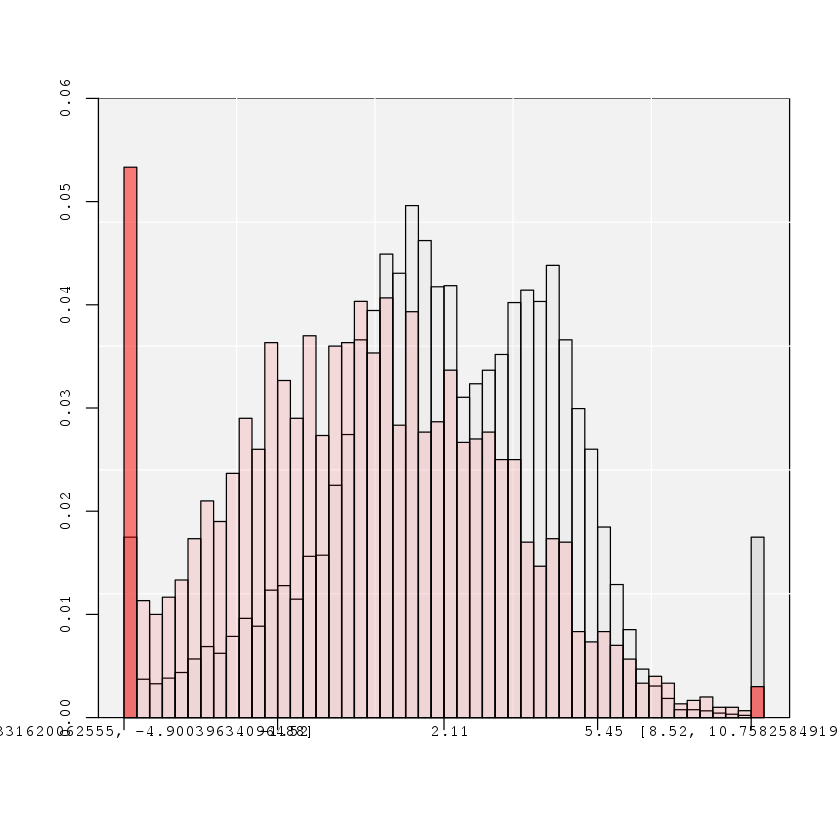

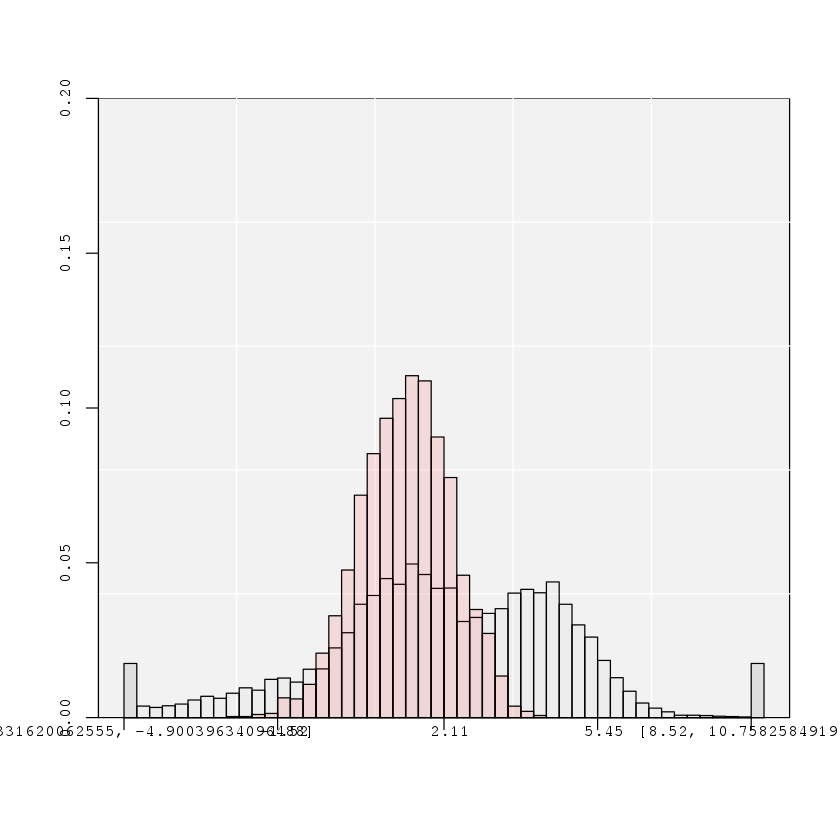

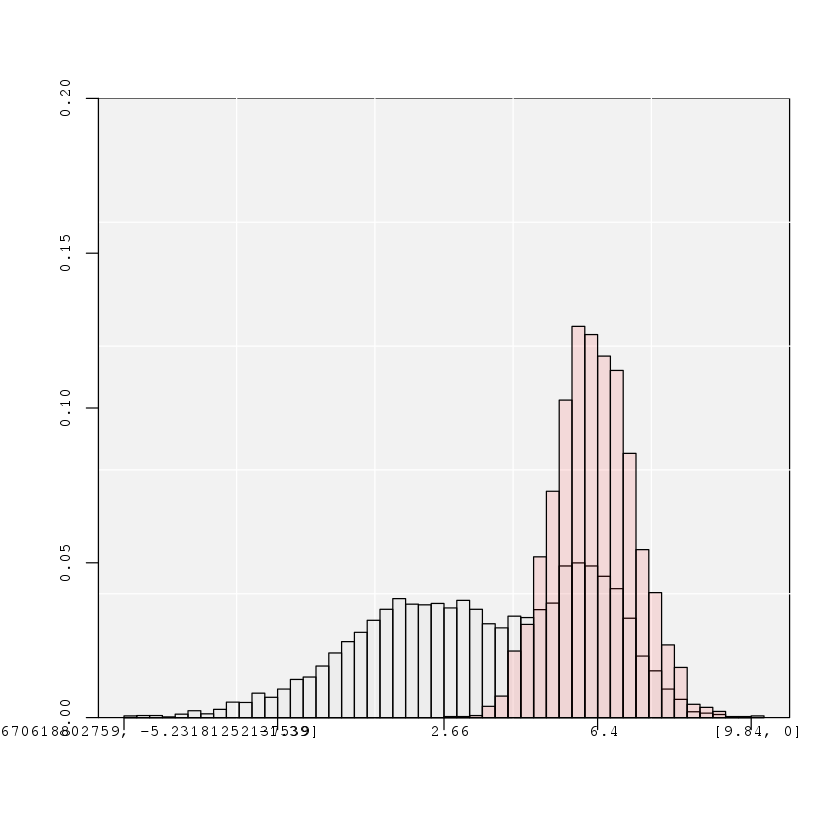

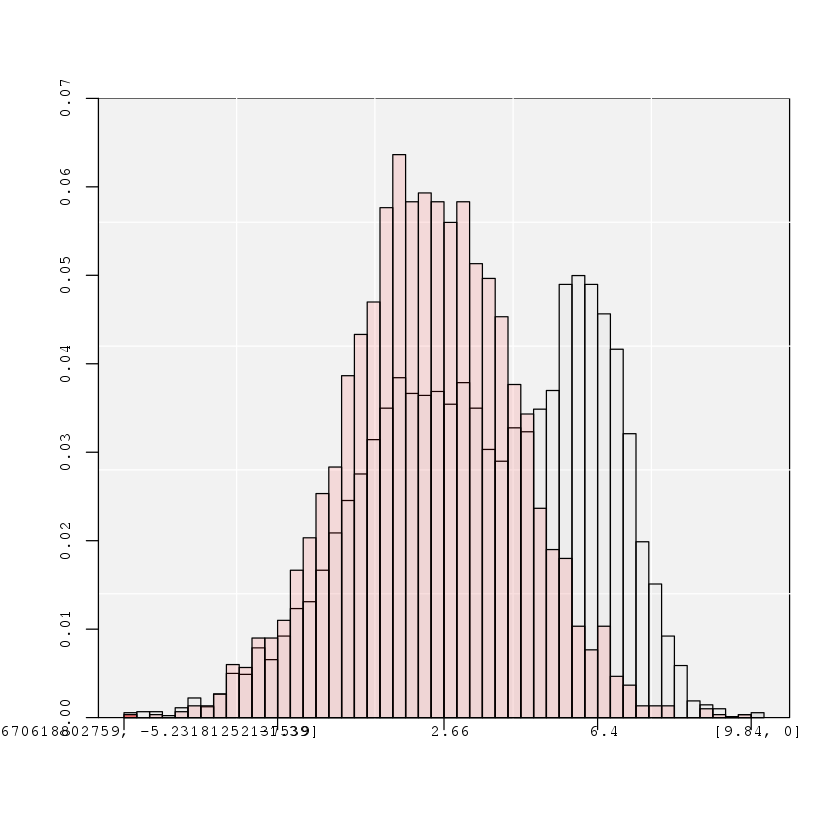

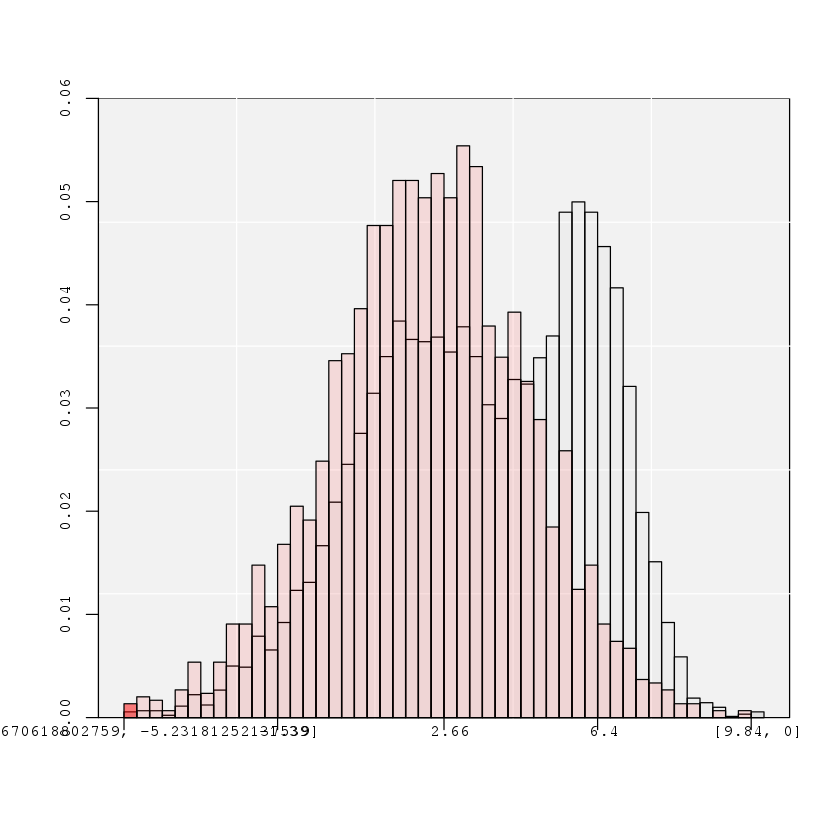

In [32]:
source('lib/MDMM_plot_tools.R')

# plot gaussian data
for ( i in 1:2)	{
  for (k in 1:3)	{
    hist_mdmm(dat[,i], dat[eval_clusters == k,i])
  }
}

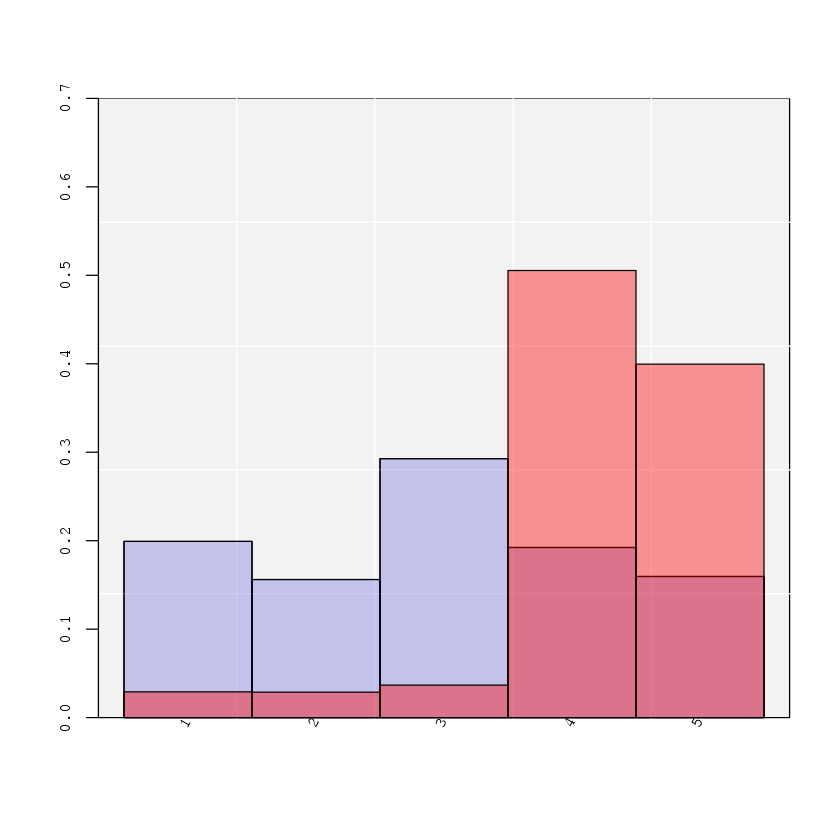

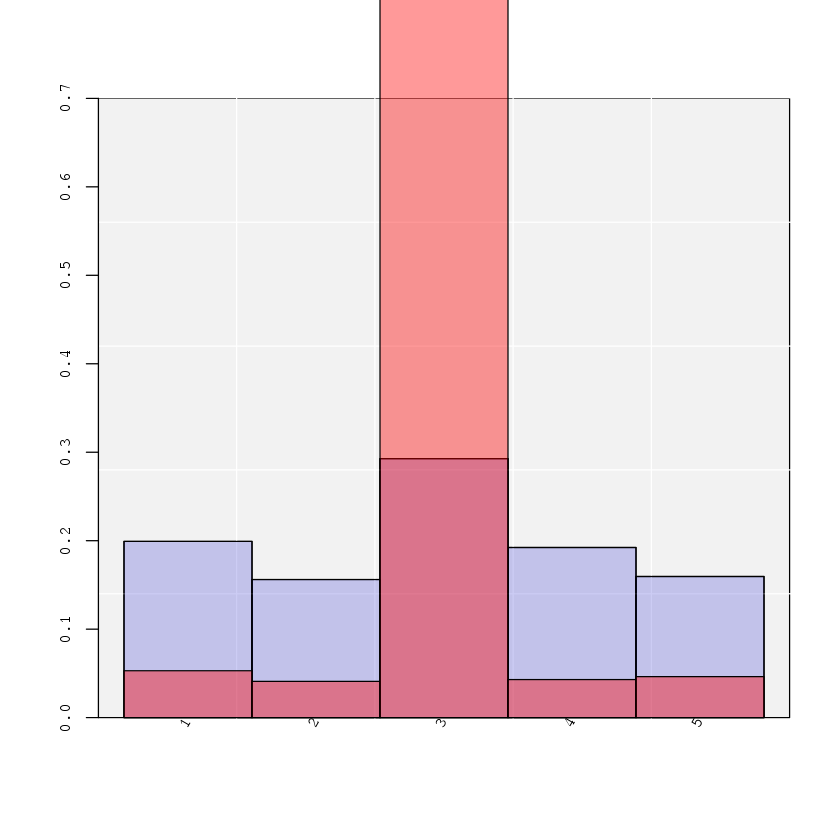

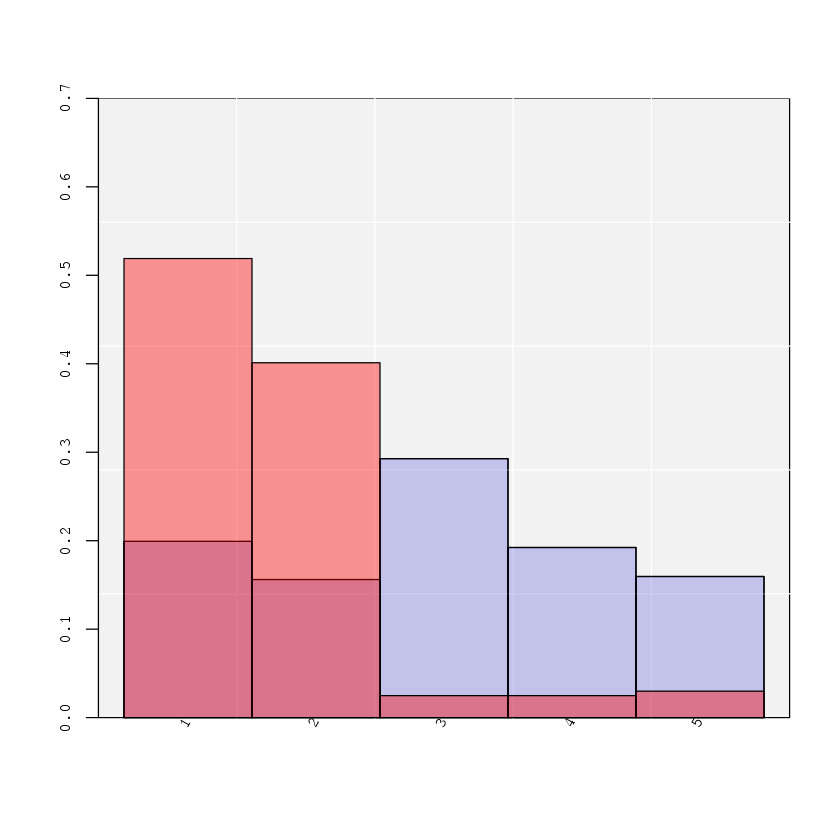

In [33]:
#plot categorical data
for (k in 1:3)	{
  barplot_mdmm(dat[,3], dat[eval_clusters == k,3], ylim = c(0,0.7))
}

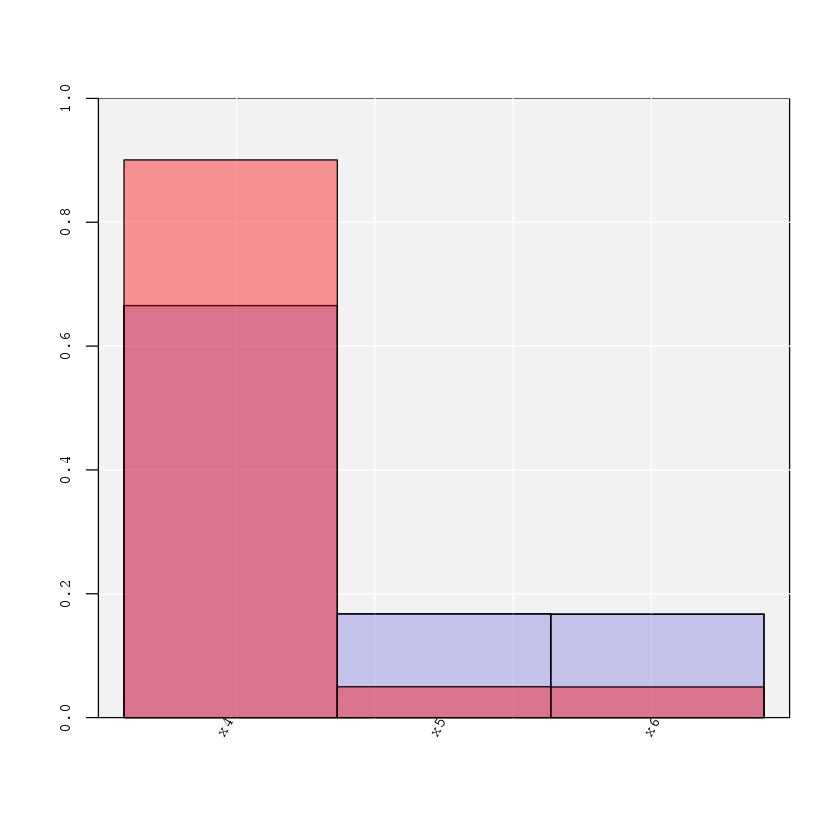

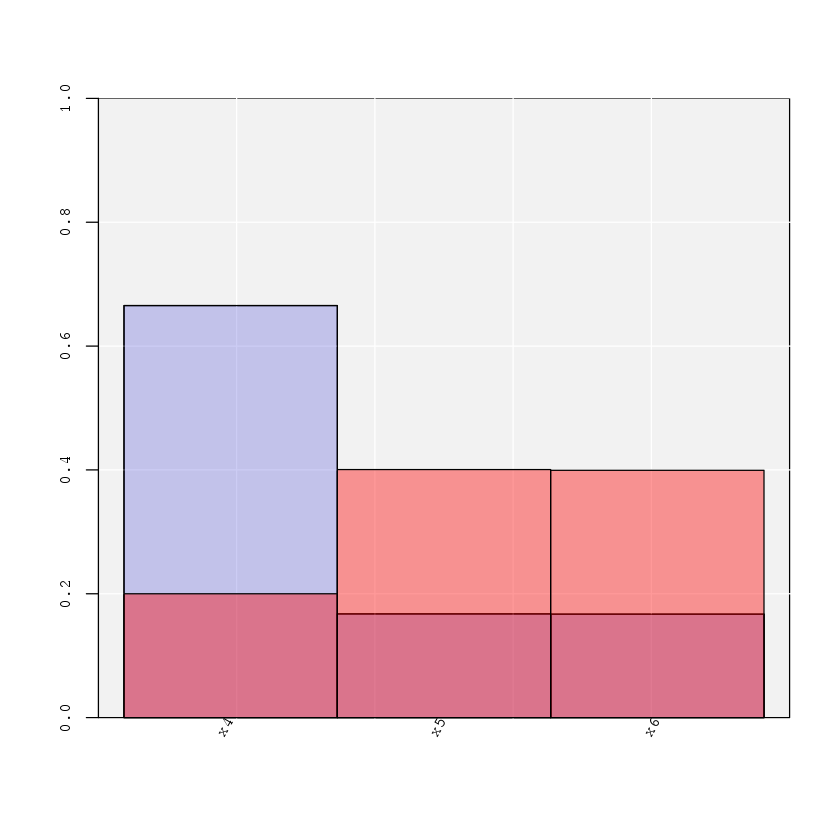

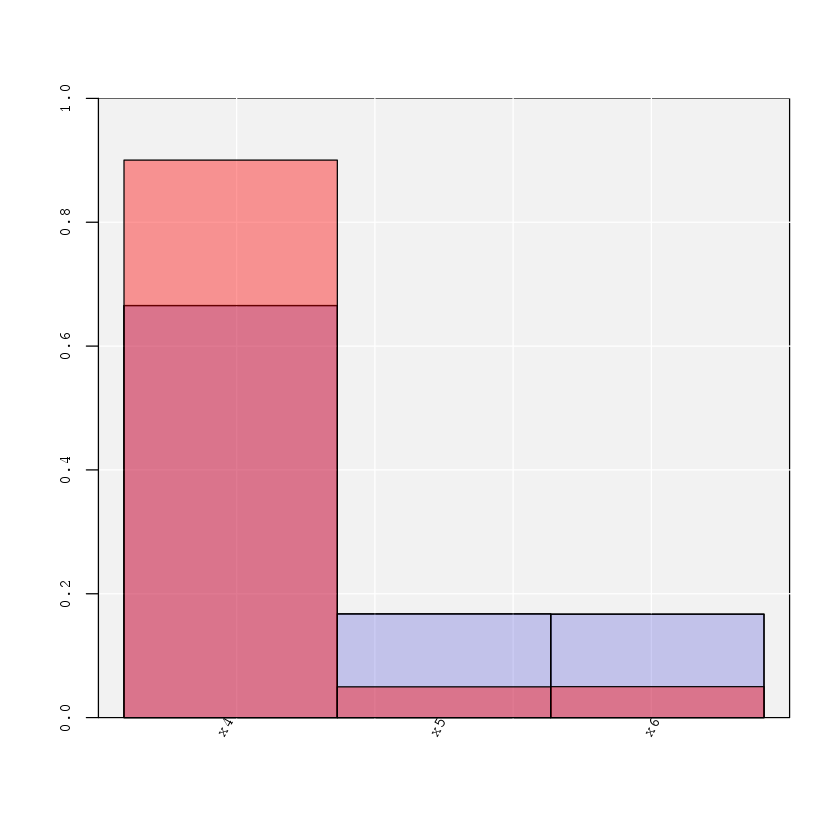

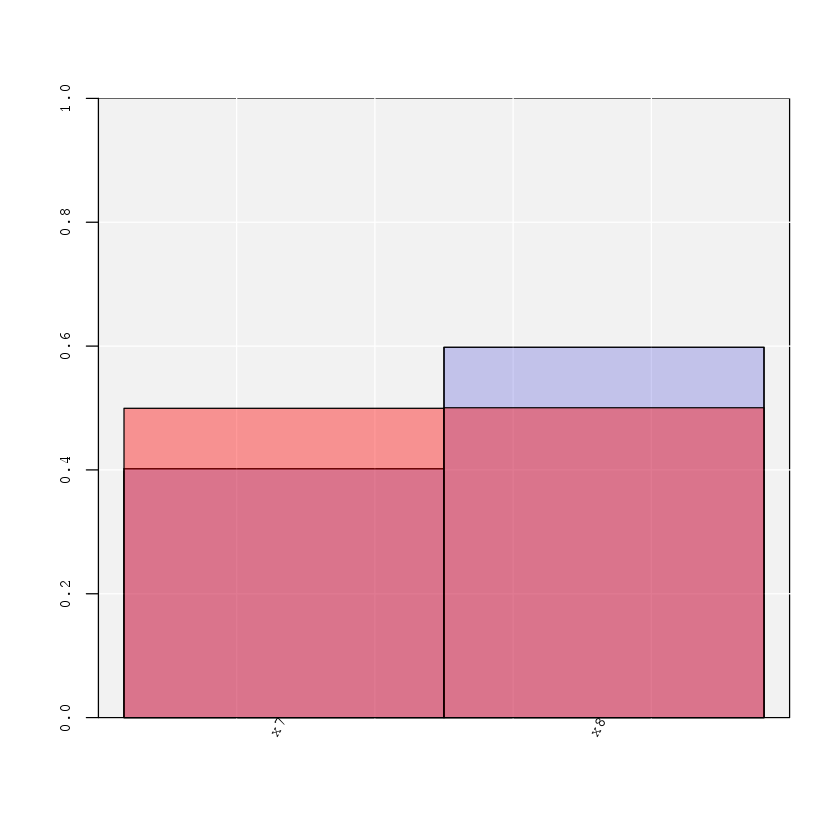

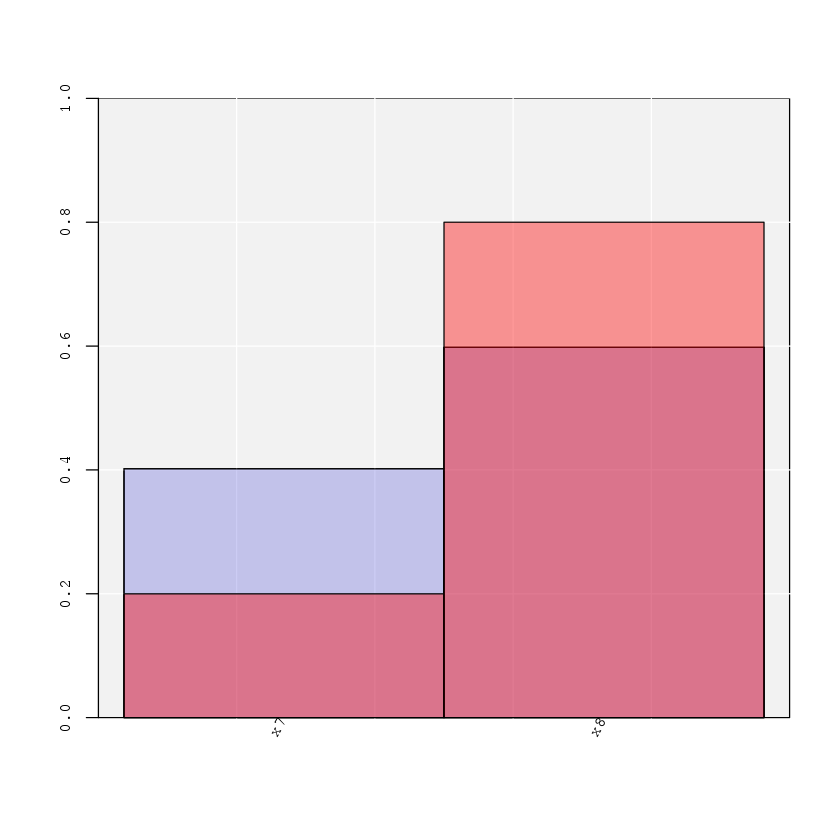

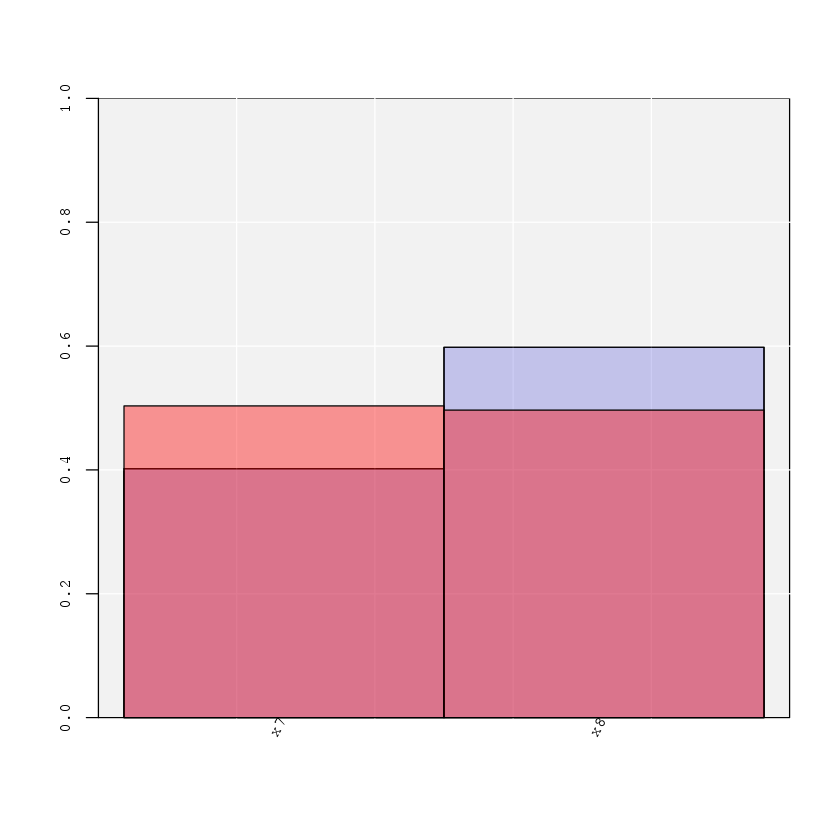

In [34]:
#plot multinomial data
for ( i in 1:2)	{
  for (k in 1:3)	{
    barplot_mdmm(dat[,idx_m[[i]]], dat[eval_clusters == k,idx_m[[i]]], ylim = c(0,1))
  }
}